## Downloading and Importing Relevant Libraries

In [101]:
!pip3 install numpy --quiet
!pip3 install pandas --quiet
!pip3 install yfinance --quiet
!pip3 install matplotlib --quiet 
!pip3 install scikit-learn --quiet 
!pip3 install tensorflow --quiet

In [102]:
import yfinance as yf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

## Downloading stock data for a particular ticker and timeframe.

In [103]:
ticker = "NVDA" 
start_date = "2019-11-25"
end_date = "2024-12-18"
nvda = yf.download(ticker, start=start_date, end=end_date)
nvda

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
2019-11-25,5.503102,5.530250,5.535250,5.388000,5.401000,506476000
2019-11-26,5.398369,5.425000,5.517250,5.418500,5.512500,385244000
2019-11-27,5.433222,5.456000,5.501250,5.429500,5.466750,215784000
2019-11-29,5.395879,5.418500,5.453500,5.394500,5.425000,141556000
2019-12-02,5.209410,5.231250,5.425000,5.216000,5.411500,372036000
...,...,...,...,...,...,...
2024-12-11,139.309998,139.309998,140.169998,135.210007,137.360001,184905200
2024-12-12,137.339996,137.339996,138.440002,135.800003,137.080002,159211400


## Visualizing the closing stock price of NVDA within our set time frame.

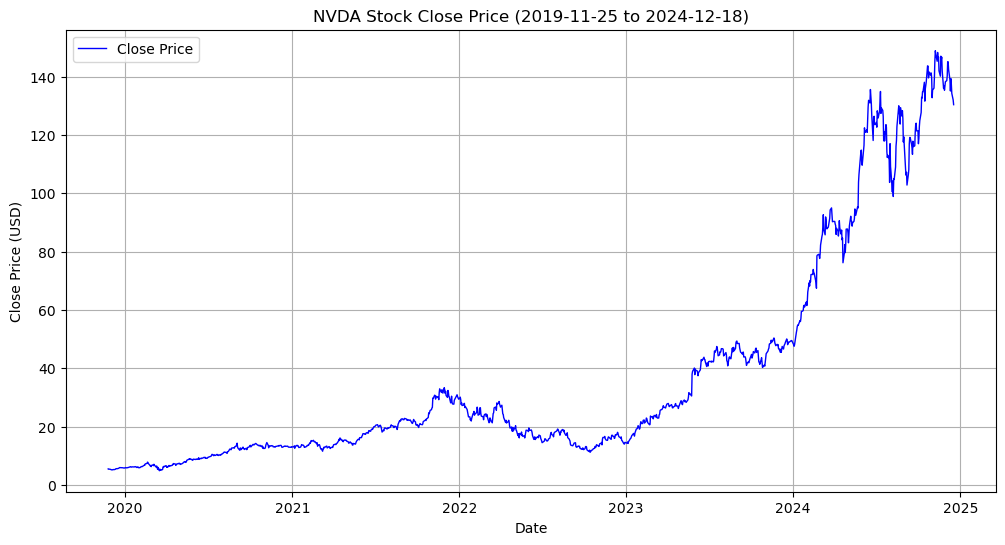

In [104]:
plt.figure(figsize=(12, 6))
plt.plot(nvda.index, nvda['Close'], color='blue', linewidth=1, label='Close Price')

# Add labels and title
plt.title(f"{ticker} Stock Close Price ({start_date} to {end_date})")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.grid(True)

## Data Preprocessing
#### LSTMs are sensitive to the scale of the data. Therefore, we need to apply the MinMax Scalar.

In [105]:
from sklearn.preprocessing import MinMaxScaler

nvda_close = nvda['Close'].values # Grabs the closing prices and stores it into a new dataframe
scaler = MinMaxScaler(feature_range=(0,1)) # Initializes the scalar that scales values from 0 to 1 
nvda_close = scaler.fit_transform(np.array(nvda_close).reshape(-1, 1)) # Applies the scalar on 'nvda_close' to scale values to between 0 and 1.

In [106]:
# Splits the data into the training and testing set in a 65-35 split.

train_set = nvda_close[:int(0.65 * len(nvda_close))] 
test_set = nvda_close[int(0.65 * len(nvda_close)):] 

In [107]:
def build_sequences(data, time_step):
    """Builds the time-step sequences to feed into the LSTM model."""
    X, Y = [], []
    for i in range(len(data) - time_step):
        input = data[i : i + time_step]
        target = data[i + time_step]

        X.append(input), Y.append(target)
    return np.array(X), np.array(Y)

In [108]:
time_step = 100

X_train, Y_train = build_sequences(train_set, time_step)
X_test, Y_test = build_sequences(test_set, time_step)

#### Reshaping the data because an LSTM requires a 3D input shape: (number of samples, timesteps, number of features)

In [109]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [111]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [112]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [113]:
model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=100,batch_size=64, verbose=1)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 0.0044 - val_loss: 0.1750
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 9.2157e-04 - val_loss: 0.0693
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 4.2004e-04 - val_loss: 0.0158
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - loss: 2.4833e-04 - val_loss: 0.0156
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 1.9666e-04 - val_loss: 0.0242
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 1.6878e-04 - val_loss: 0.0190
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 1.7646e-04 - val_loss: 0.0193
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 1.6690e-04 - val_loss: 0.0177
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 1.5728e-04 - val_loss: 0.0168
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 1.4573e-04 - val_loss: 0.0162
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 1.5008e-04 - val_loss: 0.0135
Ep

In [114]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [115]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [116]:
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(Y_train, train_predict)

17.880453386890693

In [117]:
root_mean_squared_error(Y_test, test_predict)

81.9749899455916

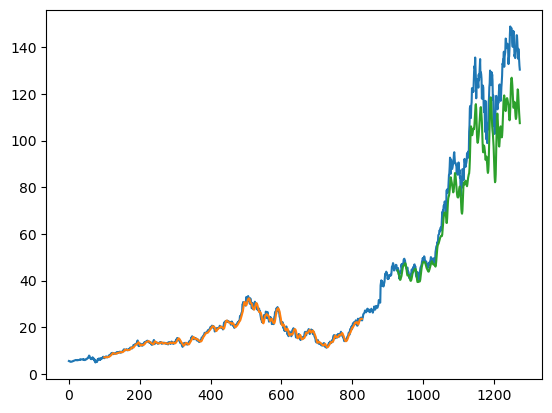

In [119]:
### Plotting
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(nvda_close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(nvda_close)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2):len(nvda_close), :] = test_predict

# plot baseline and predictions
plt. plot(scaler.inverse_transform(nvda_close))
plt.plot(trainPredictPlot)
plt.plot (testPredictPlot)
plt. show()